# Нейросети в задачих обработки текстов

**Разработчик: Алексей Озерин, Ирина Сапарина**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aosokin/dl_cshse_ami/blob/master/2021-fall/homeworks_small/shw6/DL21-fall-shw6.ipynb)


# Генерация коротких текстов с помощью Transformer


Генерировать тексты можно как с помощью RNN, так и с помощью Transformer, предсказывая следующий символ последовательности по предыдущим. Мы будем использовать архитектуру Transformer.

В этом задании предлагается написать и проучить на небольшом датасете имен генеративную модель на основе символов.

In [2]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/aosokin/dl_cshse_ami/master/2021-fall/homeworks_small/shw6/names"

names               100%[===================>]  54.56K  --.-KB/s    in 0.001s  


In [3]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

В файле `names` находится ~8k имен на латинице.

Модель будет получать на вход имя `Amandy` и выдавать его же, только со сдвигом: `mandy `.

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен `_`.

Также нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов). С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный `<EOS>` токен. В данном случае обозначим его `#`:

```
_Amandy --> Amandy#
```

Можно прекращать генерацию при досрочном выпадании `<EOS>`.

Для генерации на каждом шаге будем подавать на вход букву, предсказанную на предыдущем.



In [4]:
import os
start_token = "_"
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
_Aimil#
_Barn#
_Mada#
_Karee#
_Salomon#
_Nessi#
_Lucius#
_Yolanthe#


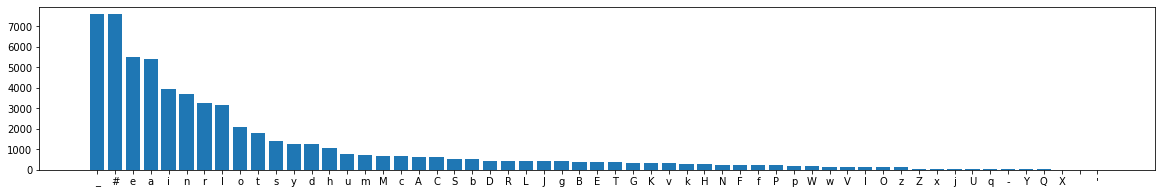

In [5]:
# TODO: постройте частоты употреблений букв
from collections import Counter
plt.rcParams["figure.figsize"] = (20,3)
c = Counter()
for name in names:
    c += Counter(name)
plt.bar(*zip(*dict(c.most_common()).items()))
plt.show()
# HINT: для графика возьмите plt.bar

max length = 17


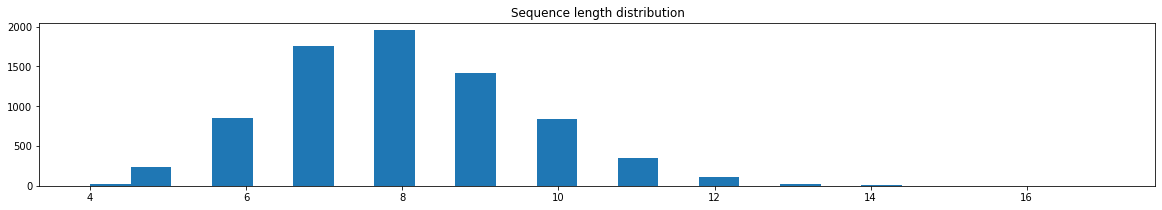

In [6]:
# в датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [7]:
names[:10]

['_Aimil#',
 '_Keri#',
 '_Quintus#',
 '_Ivonne#',
 '_Roseann#',
 '_Ulrick#',
 '_Hadleigh#',
 '_Armand#',
 '_Jock#',
 '_Chloris#']

In [8]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы start_token имел номер 0
    
tokens = list(c)
    
tok2id = dict(zip(tokens, range(len(tokens))))
id2tok = dict(zip(range(len(tokens)), tokens))

n_tokens = len(tokens)
print ('There are {} tokens'.format(n_tokens))

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 57 tokens
Vocabular: _Aiml#KerQuntsIvoRaUckHdghJCDByGEWbLFTpMXxqfSV-PNzYwZjO' 


In [9]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [10]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

_Aimil#
_Keri#
_Quintus#
_Ivonne#
_Roseann#
_Ulrick#
_Hadleigh#
_Armand#
_Jock#
_Chloris#
[[ 0  1  2  3  2  4  5 56 56 56]
 [ 0  6  7  8  2  5 56 56 56 56]
 [ 0  9 10  2 11 12 10 13  5 56]
 [ 0 14 15 16 11 11  7  5 56 56]
 [ 0 17 16 13  7 18 11 11  5 56]
 [ 0 19  4  8  2 20 21  5 56 56]
 [ 0 22 18 23  4  7  2 24 25  5]
 [ 0  1  8  3 18 11 23  5 56 56]
 [ 0 26 16 20 21  5 56 56 56 56]
 [ 0 27 25  4 16  8  2 13  5 56]]


In [11]:
# TODO: разбейте все имена на тренировочную (80%) и тестовую часть (20%)
def split_data(input):
    df = np.array(input)
    ind = np.random.permutation(len(df))
    train_size = int(len(df) * 0.8)
    return np.array(df[ind[:train_size]]), np.array(df[ind[train_size:]])

train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6062, 1516)

In [12]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

# Char-Transformer для имен

Вам нужно написать сеть, кодирующую входные символы и их позиции с помощью таблиц Embeddings. 
Получившиеся тензоры пропустить через `TransformerEncoder`, затем преобразовать в логиты для предсказания новых символов.

Transformer может обрабатывать сразу всю последовательность за один проход. Для того, чтобы у модели не было возможности "заглянуть в будущее", то есть использовать информацию о впреди идущих символах, необходимо сгенерировать маску. `TransformerEncoder` должен принимать на вход последовательность символов и маску.    
![Transformer](https://drive.google.com/uc?export=view&id=1gXILzT3mGgc0mGlvqY-6R4bGs3Lx2YxM)
Картинка из [illustrated transformer](http://jalammar.github.io/illustrated-transformer/)

In [59]:
# TODO: заполните пропуски
def generate_pos_encoder_matrix(emb_size):
    w = np.array([1 / 10000**(2*k / emb_size) for k in range(1, (emb_size + 1) // 2 + 1)])
    w2 = np.repeat(w, 2)[:emb_size]
    mask = np.arange(emb_size) == 0
    poses = np.arange(MAX_LENGTH)[:, None]
    return np.sin(poses * w2) * mask + np.cos(poses * w2) * np.logical_not(mask)


class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.pos_matrix = torch.tensor(generate_pos_encoder_matrix(emb_size), requires_grad=False)


        encoder_layer = nn.TransformerEncoderLayer(emb_size, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

        self.register_buffer("position_ids", torch.arange(MAX_LENGTH).unsqueeze(1))


    def _generate_square_subsequent_mask(self, seq_len):
        # TODO: сгенерируйте маску размера seq_len x seq_len
        # если во время кодирования i-го символа j-й символ доступен, 
        # то (i,j) элемент маски равен 0, иначе -inf
        
        mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).double()

        return mask
        
    def forward(self, input):
        # print(input.shape)
        # print(self.embeddings(input).shape)
        # print(self.pos_matrix[:len(input)].shape)
        bs = len(input)
        seq_len = input.shape[1]
        x = self.embeddings(input) 
        x += self.pos_matrix[:seq_len].repeat((bs, 1, 1))
        x = self.encoder(x, self._generate_square_subsequent_mask(seq_len))
        x = self.decoder(x)
        output = nn.functional.sigmoid(x)
        return output

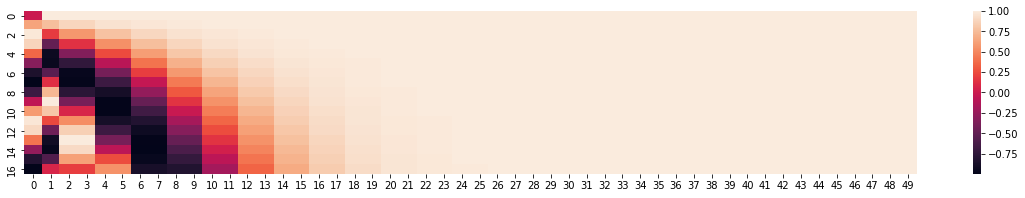

In [60]:

emb_size = 50
w = np.array([1 / 10000**(2*k / emb_size) for k in range(1, (emb_size + 1) // 2 + 1)])
w2 = np.repeat(w, 2)[:emb_size]
mask = np.arange(emb_size) == 0
poses = np.arange(MAX_LENGTH)[:, None]
ans = np.sin(poses * w2) * mask + np.cos(poses * w2) * np.logical_not(mask)
from seaborn import heatmap
heatmap(ans)

# Код для тренировки

In [110]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        
        nums = to_matrix(batch)
        output = model(torch.tensor(nums))
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output[:, :-1, :].permute([0, 2, 1]), torch.tensor(nums)[:, 1:])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        
        nums = to_matrix(batch)
        
        output = model(torch.tensor(nums))
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output[:, :-1, :].permute([0, 2, 1]), torch.tensor(nums)[:, 1:])
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

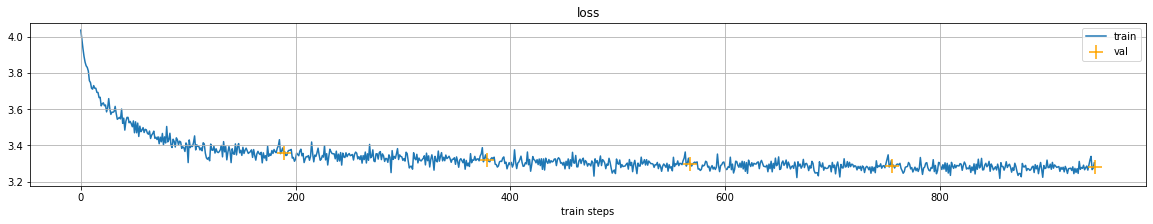

In [111]:
import math
model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, 5)

# Генерация по argmax

In [133]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
    return torch.max(logits, dim=-1)[1]

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix="_"):
    nums = to_matrix([prefix])
    nums = torch.from_numpy(nums)
    
    # TODO: сначала подайте на вход префикс
    # нас интересует последний output, чтобы получить первое предсказание
    model.eval()
    last_char_num = None
    outs = []
    # TODO: затем сгенерируйте несколько последующих символов
    # outs -- это массив с номерами токенов
    for i in range(MAX_LENGTH):
        last_char_num = pick_by_argmax(model(nums)[0])[-1].unsqueeze(0)
        outs.append(last_char_num.item())
        nums = torch.cat((nums[0], last_char_num)).unsqueeze(0)
        if last_char_num.item() == tok2id['#']:
            break
    
    print(prefix + '|'+ ids2string(outs))
    return outs
gen_continuation(model, "_Ku")

_Ku|nare#


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[11, 18, 8, 7, 5]

# Генерация с семплированием

Обычный софтмакс 
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
можно модернизировать с помощью температуры:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

Это позволит плавно переходить от выбора наиболее вероятного элемента ($T << 1$) до практически равновероятного ($T >> 1$)


In [163]:
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2string(ids, prefix):
    # модифицируйте ids2string для работы с батчами
    return [prefix + ids2string(id) for id in ids]

def pick_by_distribution(logits, t):
    # превратите логиты в распределение
    # затем семлируйте из него batch примеров
    return nn.functional.softmax(logits / t)
    


def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10):
    nums = to_matrix([prefix])
    nums = torch.from_numpy(nums)
    samples = np.random.choice(tokens, n, p=pick_by_distribution(model(nums)[0][-1], temperature).detach().numpy(), replace=False)

    outs = [gen_continuation(model, prefix + s) for s in samples] 
    # аналогично, сначала подайте на вход префикс
    # нас интересует последний output, чтобы получить первое предсказание
    
    
    # затем, сгенерируйте n последующих символов
    # в outs положите матрицу номеров токенов и отобразите ее
    
    print(batch2string(outs, prefix + '|'))
    return outs

In [164]:
gen_continuation_temp(model, prefix=" An", temperature=0.5, n=10)

 AnD|in#
 Ant|ine#
 Ann|are#
 Ano|re#
 Anm|in#
 Any|nan#
 AnA|rin#
 And|in#
 Ane|lle#
 Anr|in#
[' An|in#', ' An|ine#', ' An|are#', ' An|re#', ' An|in#', ' An|nan#', ' An|rin#', ' An|in#', ' An|lle#', ' An|in#']


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


[[2, 11, 5],
 [2, 11, 7, 5],
 [18, 8, 7, 5],
 [8, 7, 5],
 [2, 11, 5],
 [11, 18, 11, 5],
 [8, 2, 11, 5],
 [2, 11, 5],
 [4, 4, 7, 5],
 [2, 11, 5]]

In [142]:
model(nums)[0][-1]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([1.7669e-04, 1.6401e-03, 5.0197e-01, 9.6112e-01, 9.9989e-01, 4.0700e-02,
        4.2013e-03, 8.9885e-01, 9.9872e-01, 7.0889e-04, 3.5542e-02, 9.9998e-01,
        9.8524e-01, 9.9937e-01, 1.0974e-03, 4.3077e-01, 1.9610e-01, 1.5188e-03,
        9.7998e-01, 5.8789e-04, 8.7642e-01, 7.0601e-03, 7.0747e-04, 9.9192e-01,
        7.0391e-01, 4.6275e-04, 8.4442e-04, 1.3336e-03, 1.2212e-03, 1.5762e-03,
        9.4154e-03, 7.1020e-04, 1.6553e-03, 1.2255e-03, 7.4442e-01, 1.5866e-03,
        4.8632e-03, 9.7036e-04, 4.6645e-03, 1.3317e-03, 1.3118e-03, 8.4864e-04,
        8.3103e-04, 5.1422e-03, 1.0243e-03, 2.0867e-03, 7.4855e-04, 1.4148e-03,
        9.7536e-04, 7.2969e-03, 8.9294e-04, 2.6213e-03, 1.0319e-03, 8.2625e-04,
        2.1607e-03, 4.4302e-04, 3.4538e-03], grad_fn=<SelectBackward>)